In [1]:
import sys
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15,9)

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import NMF
from pathlib import Path

from utils import utils, files, generate_mappings, analysis, plot

# protocol

1. record calibration dataset and extract per-channel variances
2. do PCA on the variance-scaled calibration dataset in order for PCs to not be contaminated by channel scales and choose PCs to make a linear decoder
3. in the center-hold-reach-out task, scale each incoming EMG channel by its calibration variance
4. project center-hold samples onto decoder PCs (and subsequently filter)

TODO:

- add scaling to bonsai for center-hold task
  - pick up scaling array from python / subject folder `variance.bin`
  - this is a diagonal matrix `np.diag(vars)`

NOTES:

- variances in natural movement task are not always similar to that of the calibration, so we opt not to scale the calibration task by the natural movement task
- one option to deal with "loud" channels is to keep a running variance and scale this way

# load data

In [2]:
experiment = "test_9_10_21"
subject = "andy"

movement_session = "1"
calibration_session = "0"
center_hold_session = "8" # check manually for a folder, default to the first one

In [3]:
ed = files.build_experiment_path_dict(experiment)
print(ed["subjects"].keys())

if not movement_session is None:
    path = utils.get_session_path(ed, subject, "natural_movement", "session_" + str(movement_session))
    print("movement: ", path)
    md = utils.load_movement_emg(path)
    
    print("movement: ", md.keys())

if not calibration_session is None:
    path = utils.get_session_path(ed, subject, "calibration_bars", "session_" + str(calibration_session))
    print("calibration: ", path)
    cd = utils.load_calibration_emg(path)
    print("calibration: ", cd.keys())

if not center_hold_session is None:
    path = utils.get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = utils.load_center_hold_emg(path)
    print("center hold: ", chd.keys())

data folder:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/test_9_10_21
dict_keys(['andy'])
movement:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/test_9_10_21/andy/natural_movement/session_1
movement:  dict_keys(['hand closed', 'hand open', 'index finger down', 'index finger up', 'little finger down', 'little finger up', 'middle finger down', 'middle finger up', 'ring finger down', 'ring finger up', 'wrist down', 'wrist in', 'wrist out', 'wrist up'])
calibration:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/test_9_10_21/andy/calibration_bars/session_0
calibration:  dict_keys(['0', '11', '13', '15', '16', '18', '20', '22', '25', '27', '29', '2', '31', '32', '34', '36', '38', '41', '43', '45', '47', '48', '4', '50', '52', '54', '57', '59', '61', '63', '6', '9'])
/Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/test_9_10_21/andy/center_hold/session_8
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


# highpass and compute variance

In [4]:
high_cutoff = 5

if not movement_session is None:
    concat_movement_data = utils.concat_movement_emg_trials(md)[:,:64]
    concat_movement_data = analysis.highpass(concat_movement_data,cutoff=high_cutoff)
    print(concat_movement_data.shape)
    movement_vars = np.std(concat_movement_data, axis=0)
    movement_means = np.mean(concat_movement_data, axis=0)


(252000, 64)


In [5]:

if not calibration_session is None:
    concat_calibration_data = utils.concat_emg_trials(cd)[:,:64]
    concat_calibration_data = analysis.highpass(concat_calibration_data,cutoff=high_cutoff)
    print(concat_calibration_data.shape)
    calibration_vars = np.std(concat_calibration_data, axis=0)
    calibration_means = np.mean(concat_calibration_data, axis=0)


(768000, 64)


In [6]:

if not center_hold_session is None:
    concat_center_hold_data = utils.concat_emg_trials(chd)[:,:64]
    concat_center_hold_data = analysis.highpass(concat_center_hold_data,cutoff=high_cutoff)
    print(concat_center_hold_data.shape)
    center_hold_vars = np.std(concat_center_hold_data, axis=0)
    center_hold_means = np.mean(concat_center_hold_data, axis=0)


(117170, 64)


# inspect data

-1.202953397836479 128.787141353625
min channel:  29
0.0026093829330184593 128.787141353625
(251999, 64)


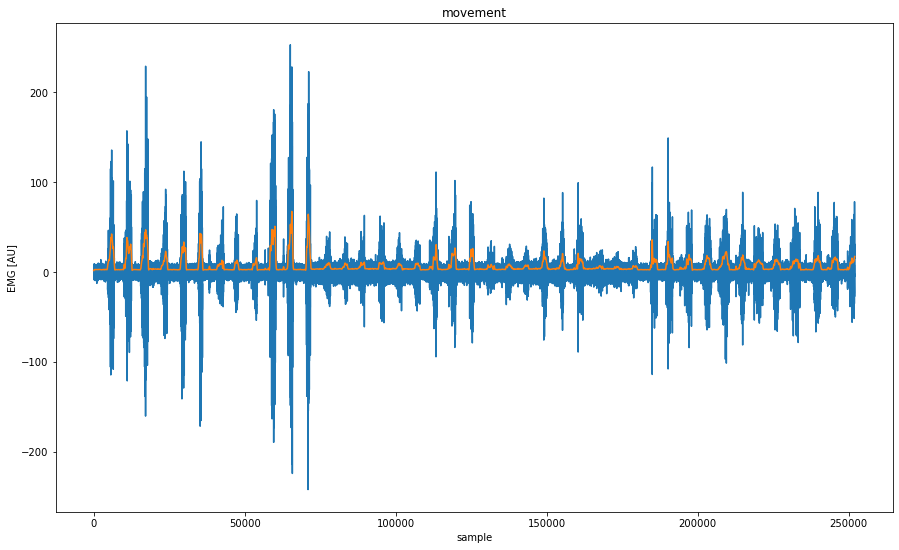

In [7]:
# plot one trial

low_cutoff = 5
start = 0
stop = -1
channel = 47

if not movement_session is None:
    plt.figure()
    hp = concat_movement_data[start:stop]
    lp = utils.filter_emg(hp)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("movement")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


-1.524196328822692 212.5011950608326
min channel:  17
1.8771289158280653e-05 212.5011950608326
(767999, 64)


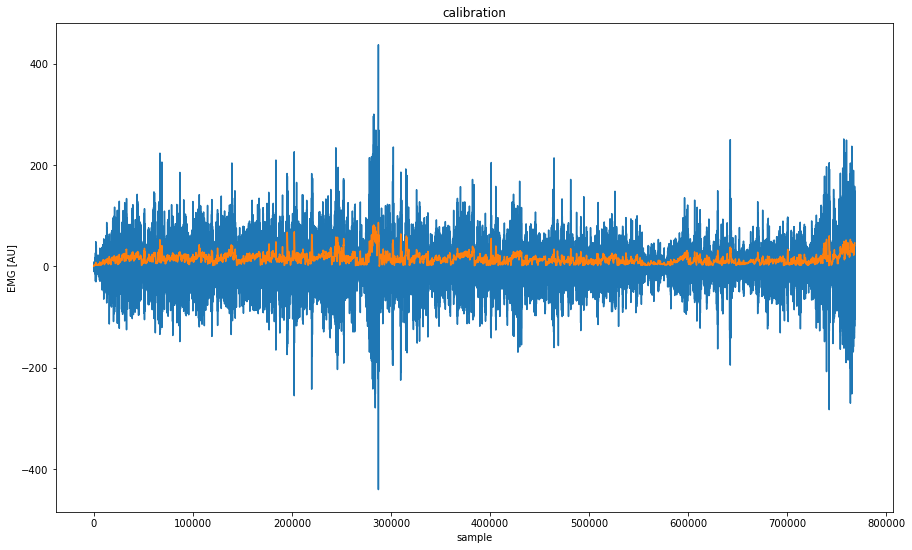

In [8]:

if not calibration_session is None:
    plt.figure()
    hp = concat_calibration_data[start:stop]
    r = analysis.rectify(hp)
    lp = utils.filter_emg(hp)
    plt.plot(hp[:,channel])
    # plt.plot(r[:,channel])
    plt.plot(lp[:,channel])
    plt.title("calibration")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


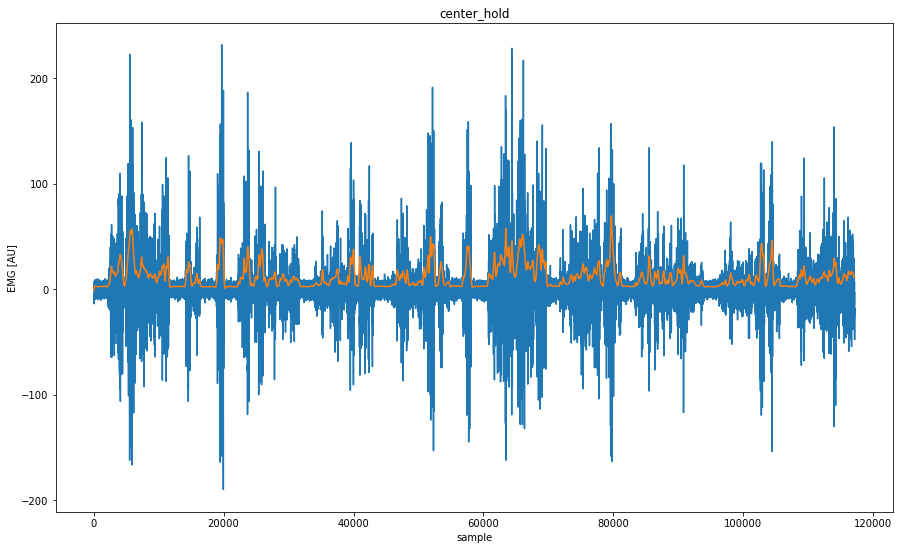

In [9]:
if not center_hold_session is None:
    plt.figure()
    hp = concat_center_hold_data[start:stop]
    lp = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("center_hold")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

# inspect mean and var

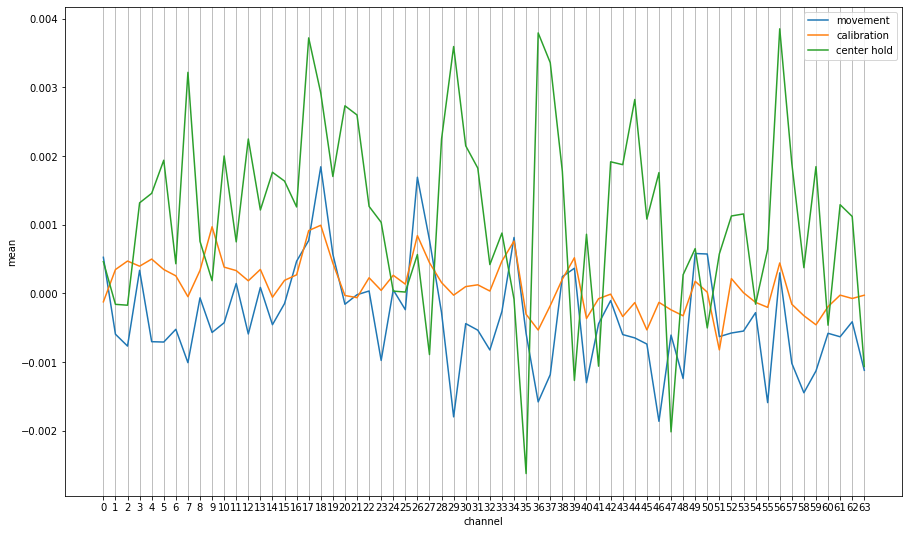

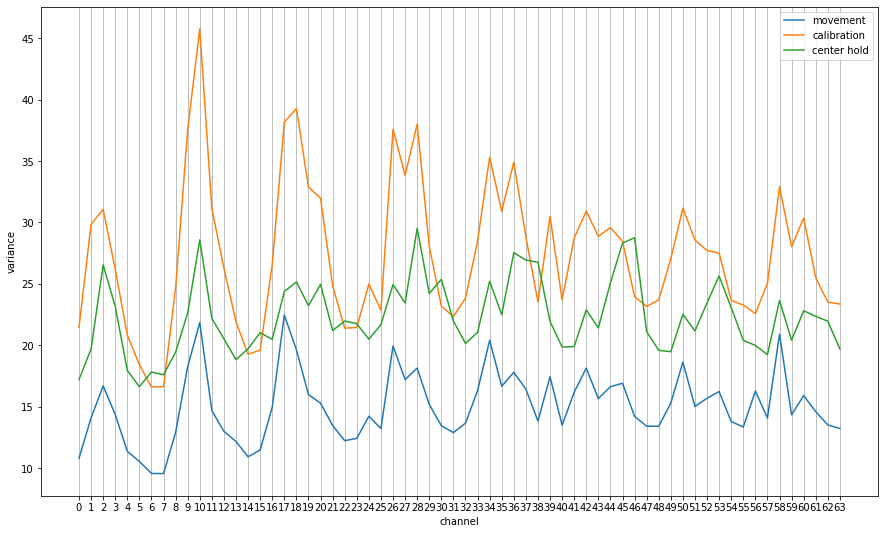

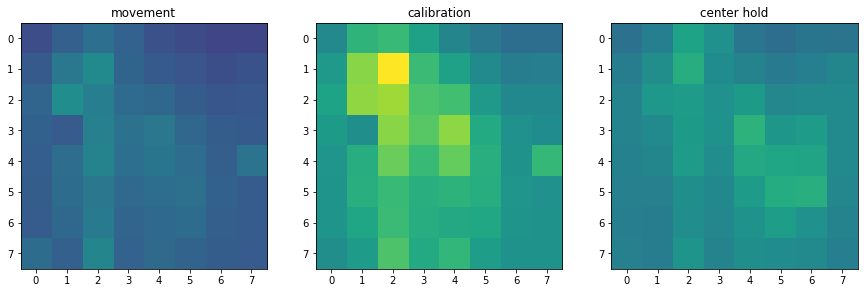

In [10]:
# mean
plt.figure()
if not movement_session is None:
    plt.plot(movement_means, label="movement")
if not calibration_session is None:
    plt.plot(calibration_means, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_means, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("mean")
plt.legend()

# variance
plt.figure()
if not movement_session is None:
    plt.plot(movement_vars, label="movement")
if not calibration_session is None:
    plt.plot(calibration_vars, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_vars, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("variance")
plt.legend()

maxes = []
if not movement_session is None:
    maxes.append(np.max(movement_vars))
if not calibration_session is None:
    maxes.append(np.max(calibration_vars))
if not center_hold_session is None:
    maxes.append(np.max(center_hold_vars))
maxmax = np.max(maxes)

fig, axes = plt.subplots(1,3)
if not movement_session is None:
    axes[0].imshow(movement_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[0].set_title("movement")
if not calibration_session is None:
    axes[1].imshow(calibration_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[1].set_title("calibration")
if not center_hold_session is None:
    axes[2].imshow(center_hold_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[2].set_title("center hold")

# compute and save variance scaling from calibration

In [11]:
v = np.diag(np.array(calibration_vars**-1, dtype=np.float32))
print(v)
print(v.shape)

# save decoder
subject_metadata_folder = utils.get_subject_folder(experiment=experiment, subject=subject)
assert subject_metadata_folder.exists()
utils.write_array_to_disk(a=v,path=subject_metadata_folder / "variance.bin")

[[0.04658033 0.         0.         ... 0.         0.         0.        ]
 [0.         0.03350911 0.         ... 0.         0.         0.        ]
 [0.         0.         0.03219943 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.03923316 0.         0.        ]
 [0.         0.         0.         ... 0.         0.04254639 0.        ]
 [0.         0.         0.         ... 0.         0.         0.04281988]]
(64, 64)


# compute offsets from movement

5
(18000, 64)
-0.04649954692510761 2.9806147427972243
min channel:  46
6.644368161251614e-05 2.9806147427972243
(18000, 64)


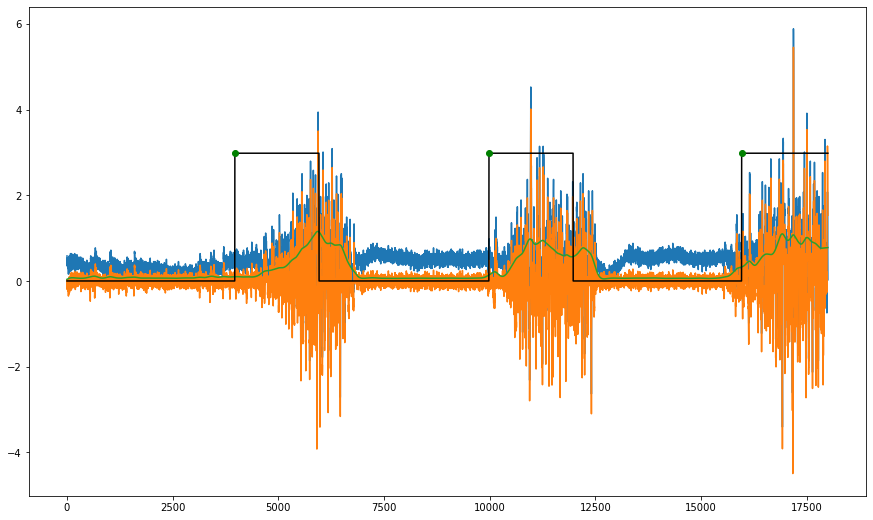

In [12]:
movements = list(md.keys())

signals = md[movements[0]]["emg"][:,:64]
print(high_cutoff)

std = utils.standardize(signals,calibration_vars)
# print(std.shape)
hp = analysis.highpass(std,cutoff=high_cutoff)
# print(r.shape)
lp = utils.filter_emg(hp)
# print(lp.shape)
cue = md[movements[0]]["cue"]
cue_on_indices = utils.get_cue_on_indices(cue)

channel = 9

plt.figure()
plt.plot(std[:,channel])
plt.plot(hp[:,channel])
plt.plot(lp[:,channel])
plt.plot(cue*np.max(lp),"k")
plt.plot(cue_on_indices,np.max(lp)*np.ones(shape=(cue_on_indices.shape[0])),'go')

(63000, 64)
-0.03930619221318606 1.120657487692162
min channel:  53
3.5717751347432476e-05 1.120657487692162
(63000, 64)
peak offset channel  5


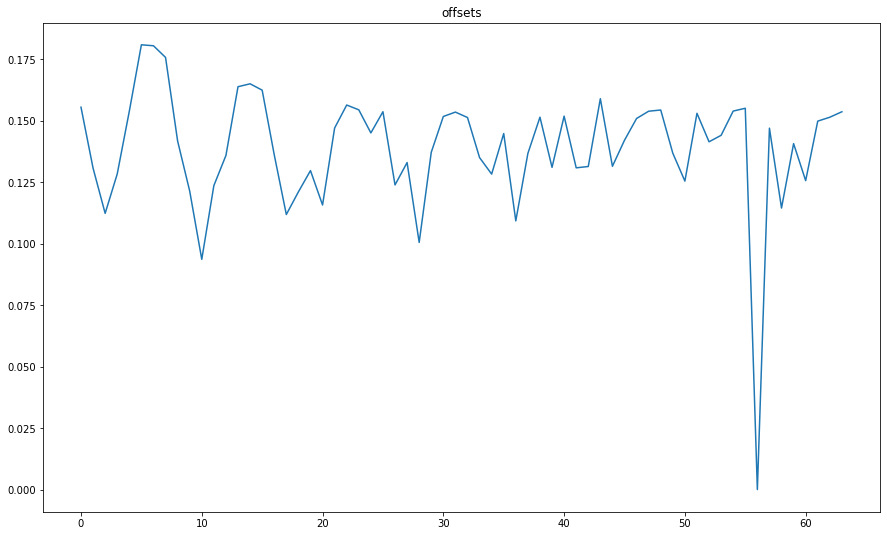

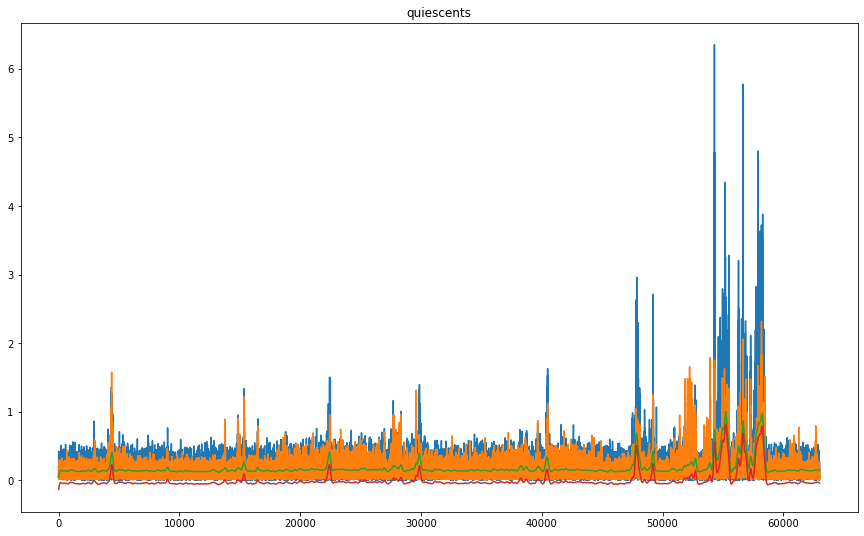

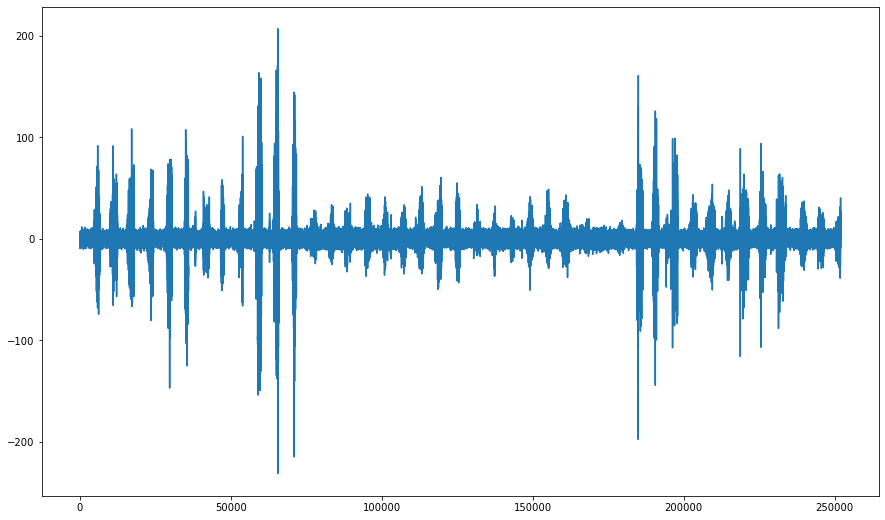

In [15]:
concat_quiescent_trials = utils.extract_quiescent(md)

quiescent_window_length = 2000 # one second

standardized_concat_quiescent_trial = utils.standardize(concat_quiescent_trials, calibration_vars)
r = analysis.rectify(standardized_concat_quiescent_trial)
lp = utils.filter_emg(standardized_concat_quiescent_trial)
dc = analysis.moving_average(r,window_length=quiescent_window_length)

offsets = np.mean(lp,axis=0).reshape(64)
# channel 56 is broken :(
offsets[56] = 0

channel = np.argmax(offsets)
print("peak offset channel ", channel)

plt.figure()
plt.plot(offsets)
plt.title("offsets")

plt.figure()
plt.plot(r[:,channel])
plt.plot(dc[:,channel])
plt.plot(lp[:,channel])
plt.plot((lp-offsets)[:,channel])
plt.title("quiescents")

plt.figure()
plt.plot(concat_movement_data[:,channel])


# save offsets

In [16]:
utils.write_array_to_disk(offsets.reshape(-1,1),subject_metadata_folder / "offsets.bin")

# standardize (variance), filter, shift (offset)

In [17]:
channel = 42

(768000, 64)
-0.04890908486523242 4.642830432537835
min channel:  52
6.0442486243938e-07 4.642830432537835
(768000, 64)


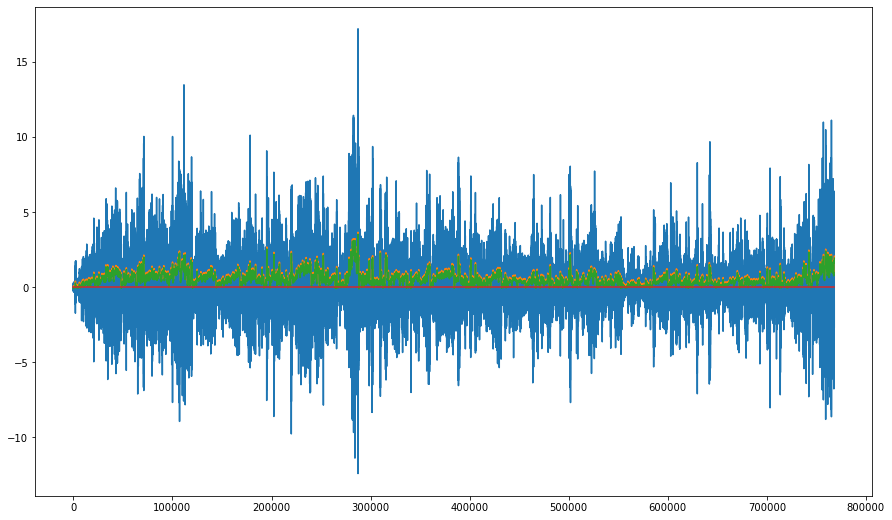

In [18]:
standardized_calibration_data = utils.standardize(concat_calibration_data, calibration_vars)
filtered_calibration_data = utils.filter_emg(standardized_calibration_data)
offset_calibration_data = np.subtract(filtered_calibration_data,offsets.reshape(-1))
plt.plot(standardized_calibration_data[:,channel])
plt.plot(filtered_calibration_data[:,channel])
plt.plot(offset_calibration_data[:,channel])
plt.plot([0,filtered_calibration_data.shape[0]],[0,0])

# movement

(252000, 64)
-0.04649954692510924 3.3730226880287835
min channel:  46
6.644368161533277e-05 3.3730226880287835
(252000, 64)


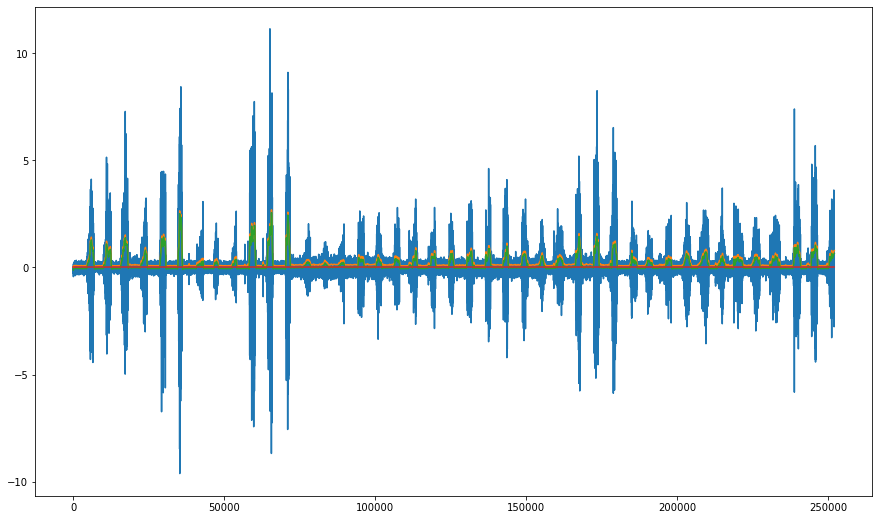

In [19]:
standardized_movement_data = utils.standardize(concat_movement_data, calibration_vars)
filtered_movement_data = utils.filter_emg(standardized_movement_data)
offset_movement_data = np.subtract(filtered_movement_data,offsets.reshape(-1))
plt.plot(standardized_movement_data[:,channel])
plt.plot(filtered_movement_data[:,channel])
plt.plot(offset_movement_data[:,channel])
plt.plot([0,filtered_movement_data.shape[0]],[0,0])

# center hold

(117170, 64)
-0.06302426249575407 5.238459515537082
min channel:  47
9.458028270211913e-06 5.238459515537082
(117170, 64)


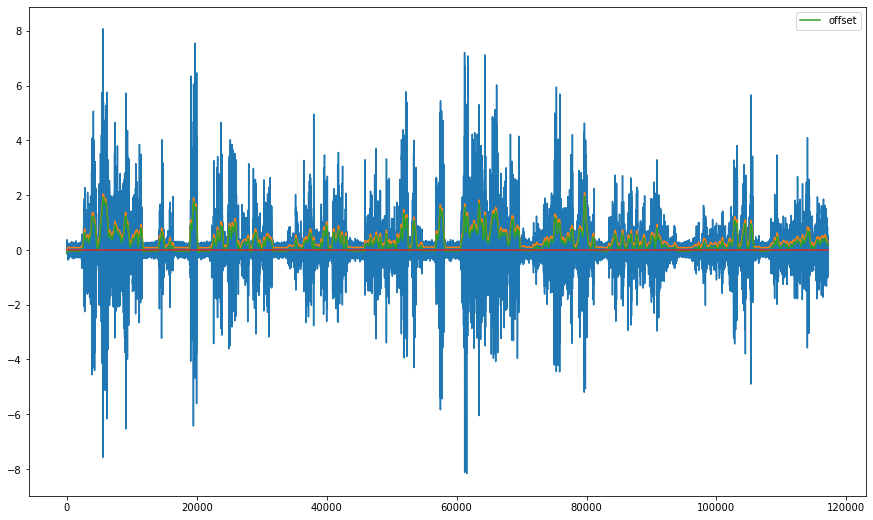

In [20]:
if not center_hold_session is None:
    standardized_center_hold_data = utils.standardize(concat_center_hold_data, calibration_vars)
    filtered_center_hold_data = utils.filter_emg(standardized_center_hold_data)
    offset_center_hold_data = np.subtract(filtered_center_hold_data,offsets)
    plt.plot(standardized_center_hold_data[:,channel])
    plt.plot(filtered_center_hold_data[:,channel])
    plt.plot(offset_center_hold_data[:,channel],label="offset")
    plt.plot([0,filtered_center_hold_data.shape[0]],[0,0])
    plt.legend()

# NMF

we L1-regularize the output (the projection of the data, W) to encourage the decoder to allow for single modes to be active at once

we can check this by looking at the correlation between the transformed data and seeking the least correlated projections

$$WH   =  X$$

TxK x Kx64 = Tx64

transformation x components = data

factors x weights = data

inverse:

$$W = XH^{-1}$$
$$W^T = H^{-T}X^T$$

KxT = Kx64 x 64xT

In [21]:
num_nmf_components = 4
nmf_model = NMF(n_components=num_nmf_components, max_iter=500, l1_ratio=0.9, regularization="transformation", random_state=0)
nmf_model.fit(filtered_calibration_data)

/Users/spencerw/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/spencerw/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(l1_ratio=0.9, max_iter=500, n_components=4, random_state=0,
    regularization='transformation')

In [22]:
nmf_components = nmf_model.components_
factors = nmf_model.transform(filtered_calibration_data)
print("components: ", nmf_components.shape)
print("factors: ", factors.shape)

norms = np.linalg.norm(nmf_components,axis=1).reshape(num_nmf_components,1)
normalized_nmf_components = np.divide(nmf_components, norms)
print(normalized_nmf_components.shape)

components:  (4, 64)
factors:  (768000, 4)
(4, 64)


# plot components and factors

0.0 0.41720864671458774


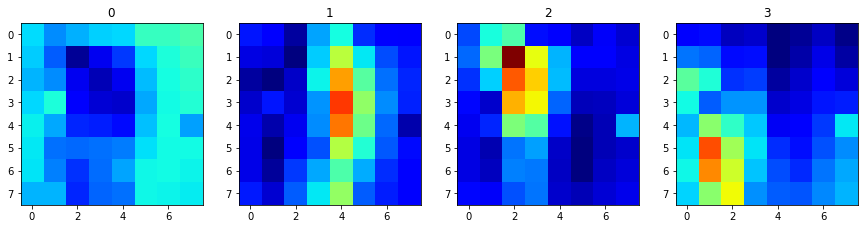

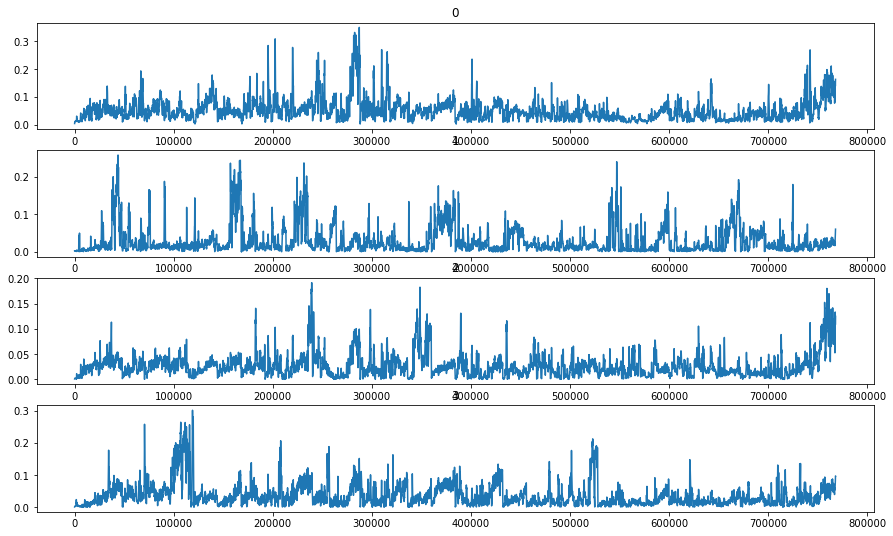

In [23]:
fig, axes = plt.subplots(1,num_nmf_components)
for i, (ax, c) in enumerate(zip(axes,normalized_nmf_components)):
    ax.imshow(c.reshape(8,8),vmin=0,vmax=np.max(normalized_nmf_components),cmap="jet")
    ax.set_title(i)
print(np.min(normalized_nmf_components),np.max(normalized_nmf_components))

fig, axes = plt.subplots(num_nmf_components,1)
for i, (ax, c) in enumerate(zip(axes,factors.T)):
    ax.plot(c)
    ax.set_title(i)


# compute inverse components

In [24]:
inv_components = np.linalg.pinv(normalized_nmf_components).T
print(inv_components.shape)
inv_norms = np.linalg.norm(inv_components,axis=1).reshape(num_nmf_components,1)
print(inv_norms.shape)
normalized_inv_components = np.divide(inv_components, inv_norms)

(4, 64)
(4, 1)


# plot inverse components and factors

-0.23354297173349792 0.49383407271074226 0.0246720034497555


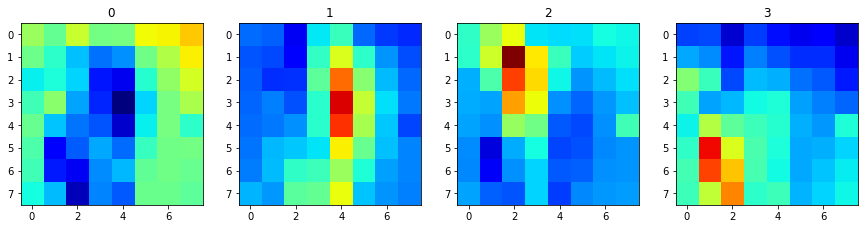

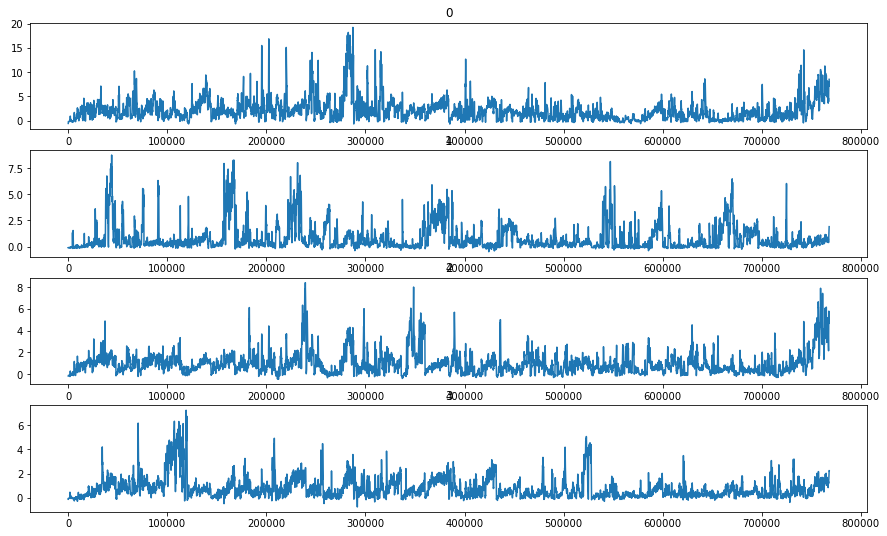

In [25]:
fig, axes = plt.subplots(1,num_nmf_components)
for i, (ax, c) in enumerate(zip(axes,normalized_inv_components)):
    ax.imshow(c.reshape(8,8),vmin=np.min(normalized_inv_components),vmax=np.max(normalized_inv_components),cmap="jet")
    ax.set_title(i)
print(np.min(normalized_inv_components),np.max(normalized_inv_components), np.mean(normalized_inv_components))

inverse_factors = np.dot(inv_components, offset_calibration_data.T)
fig, axes = plt.subplots(num_nmf_components,1)
for i, (ax, c) in enumerate(zip(axes,inverse_factors)):
    ax.plot(c)
    ax.set_title(i)

# compute decoder

In [26]:
component_idxs = [0,1,2,3]

In [27]:
# make decoder (right,left,down,up)
decoder = np.array(normalized_inv_components[component_idxs],dtype=np.float32)
print(decoder.shape)

# convert to 2D (subtract right-left up-down)
convert_to_2d = np.array([[1,-1,0,0],[0,0,-1,1]])
two_dim_decoder = np.dot(convert_to_2d, decoder)
print(two_dim_decoder.shape)

# save decoder
# subject_metadata_folder = utils.get_subject_folder(experiment=experiment, subject=subject)
six_dim_decoder = np.array(np.vstack([np.zeros(shape=(4,64)), two_dim_decoder]),dtype=np.float32)
print(six_dim_decoder.shape)
print(six_dim_decoder.dtype)

(4, 64)
(2, 64)
(6, 64)
float32


# compute dynamics

In [28]:
# add the dynamics
experiment_metadata_dict = utils.get_experiment_metadata(experiment)
dynamics = generate_mappings.generate_dynamics(decay=experiment_metadata_dict["decay"], tau=experiment_metadata_dict["tau"], stiffness=experiment_metadata_dict["stiffness"])
print(dynamics)

[[ 0.1   0.    0.7   0.    0.    0.  ]
 [ 0.    0.1   0.    0.7   0.    0.  ]
 [ 0.    0.    0.1   0.    0.7   0.  ]
 [ 0.    0.    0.    0.1   0.    0.7 ]
 [-0.05  0.    0.    0.    0.    0.  ]
 [ 0.   -0.05  0.    0.    0.    0.  ]]


# plot dynamics

No handles with labels found to put in legend.


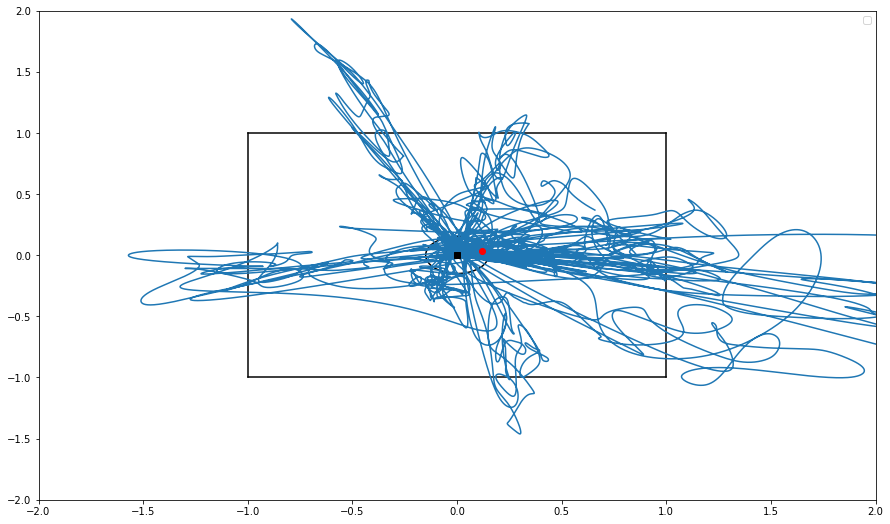

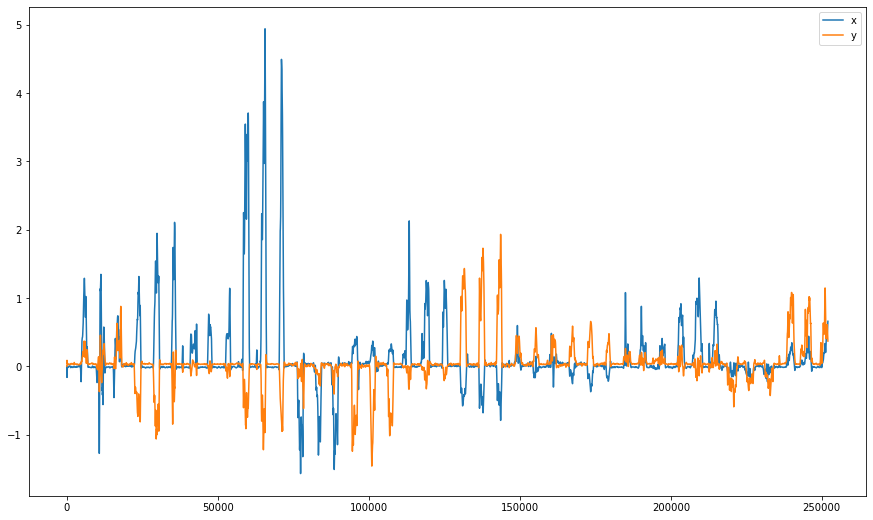

In [29]:
def plot_circle(x,y,r,ax,style="k"):
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(r*np.cos(theta)+x, r*np.sin(theta)+y,style)
    
def plot_box(ax):
    ax.plot(0,0,'ks',zorder=20)
    plot_circle(0,0,.15,ax)
    ax.plot([-1,1],[-1,-1],"k")
    ax.plot([-1,1],[1,1],"k")
    ax.plot([1,1],[-1,1],"k")
    ax.plot([-1,-1],[-1,1],"k")
    
def plot_control_preview(data, decoder, ax, label=""):
    ax.plot(np.dot(decoder[-1:],data.T)[0],np.dot(decoder[-2:-1],data.T)[0],label=label)
    ax.plot(np.dot(decoder[-1:],data.T)[0].mean(),np.dot(decoder[-2:-1],data.T)[0].mean(),"o",label=label+"mean",zorder=10)

def plot_dynamics_preview(data, dynamics, decoder, label=""):
    fig, ax = plt.subplots(1,1)
    states = []
    state = np.zeros(shape=(6,1))
    for sample in data:
        state = utils.advance_dynamics(dynamics,state,decoder,sample.reshape(-1,1))
        states.append(state)
    states = np.hstack(states)
    ax.set_ylim([-2,2])
    ax.set_xlim([-2,2])
    plot_box(ax)
    # plot_control_preview(offset_movement_data, decoder, ax)
    ax.plot(states[0],states[1])
    ax.plot(states[0].mean(),states[1].mean(),"ro")
    ax.legend()
    return states
    
states = plot_dynamics_preview(offset_movement_data, dynamics, six_dim_decoder, label="movement")

fig, ax = plt.subplots(1,1)
ax.plot(states[0],label="x")
ax.plot(states[1],label="y")
ax.legend()
ax.legend()


# save decoder

In [30]:
utils.write_array_to_disk(six_dim_decoder, subject_metadata_folder / "decoder.bin")

# save dynamics

In [31]:
utils.write_array_to_disk(dynamics, subject_metadata_folder / "dynamics.bin")

# save model and components

In [32]:
with open(subject_metadata_folder / "nmf_model.pkl", 'wb') as fp:
    pickle.dump(nmf_model, fp)

subject_metadata_dict = utils.get_subject_metadata(experiment,subject)
subject_metadata_dict.update({"components":component_idxs})

with open(str(utils.get_subject_folder(experiment,subject)/"metadata.json"), mode="w") as fp:
    json.dump(subject_metadata_dict, fp)

utils.get_subject_metadata(experiment,subject)

{'name': 'andy', 'components': [0, 1, 2, 3]}

# load and test decoder

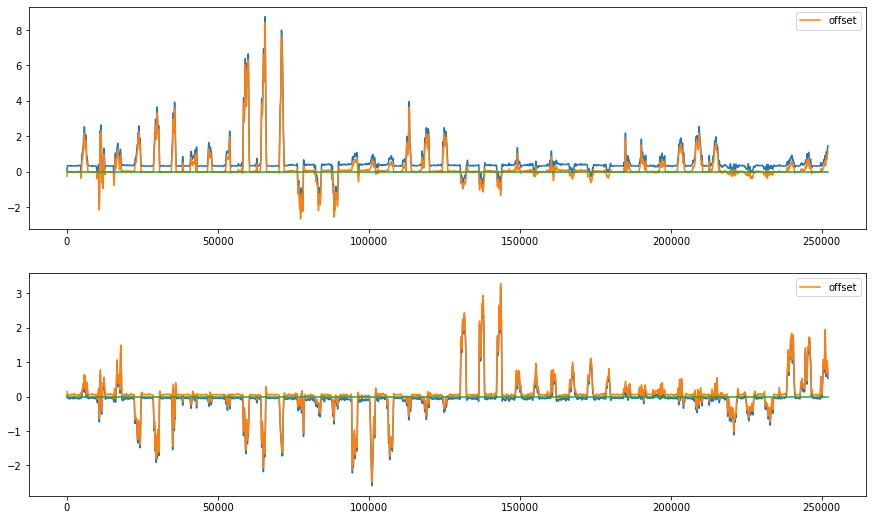

In [33]:
decoder = utils.load_array_from_disk(subject_metadata_folder / "decoder.bin").reshape(6,64)

# 2D preview
fig, axes = plt.subplots(2,1)
for ax, c in zip(axes,decoder[-2:]):
    baseline = np.dot(c,filtered_movement_data.T)
    ax.plot(baseline)
    baseline = np.dot(c,offset_movement_data.T)
    ax.plot(baseline,label="offset")
    ax.plot([0,baseline.shape[0]],[0,0])
    ax.legend()

# load and test model

In [34]:
with open(subject_metadata_folder / "nmf_model.pkl", 'rb') as fp:
    m = pickle.load(fp)

subject_metadata = utils.get_subject_metadata(experiment, subject)
nmf_components = m.components_[subject_metadata["components"]]
print(nmf_components.shape)

(4, 64)


In [86]:
# fig, axes = plt.subplots(1,2)

# # mode covariance
# axes[0].imshow(normalized_nmf_components@normalized_nmf_components.T,vmin=0,vmax=1,cmap="jet")

# # factor covariance
# c = normalized_factors.T@normalized_factors
# print(c.min(),c.max())
# axes[1].imshow(c,vmin=0,vmax=1,cmap="jet")x